https://www.youtube.com/watch?v=TCH_1BHY58I

Building makemore Part 2: MLP

Paper implementation - https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
with open('names.txt', 'r') as f:
    names = f.readlines()



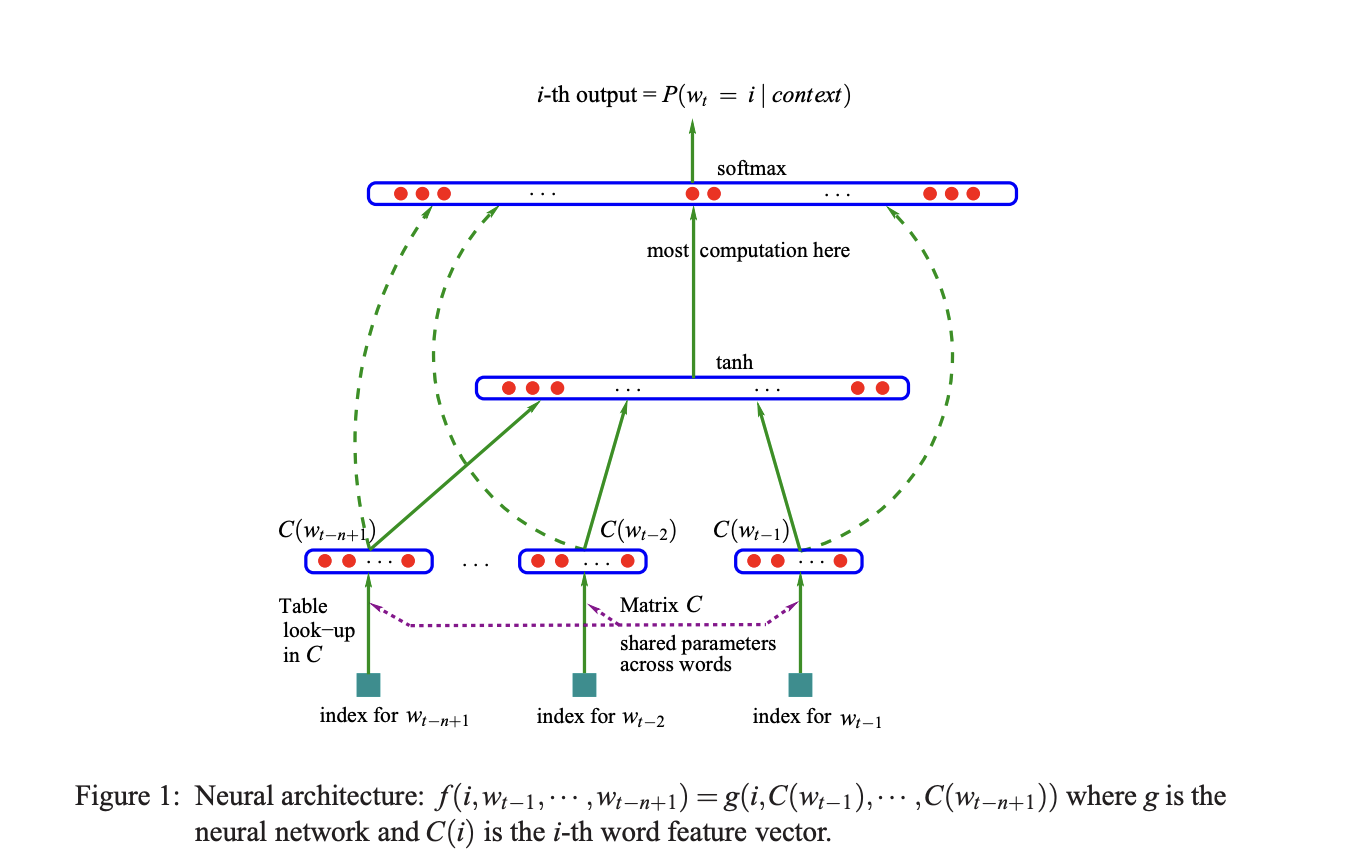

In [2]:
from IPython.display import Image, display

# If image is in the same directory as your notebook
display(Image("model.png"))

# Or with full path
# display(Image("/path/to/my_image.png"))

In [3]:
chars =  ['.'] + sorted(set( ch for name in names for ch in name.strip())) 

print(type(chars))
print(chars)
stoi = { ch:i for i, ch in enumerate(chars)}
itos = { i:ch for i, ch in enumerate(chars)}

print(stoi)
print(itos)



<class 'list'>
['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
embedding_size = 10
context_length = 3
hidden_size = 200
mini_batch = 32
epochs = 200000
lr = 0.1
weight_decay = 0.1


In [5]:
X_train  = []
Y_train = []
X_val = []
Y_val = []
import random
random.seed(42)
random.shuffle(names)
total_len = len(names)
train_len = int(total_len * 0.9)
val_len = total_len - train_len
train_names = names[:train_len]
val_names = names[train_len:]
for name in train_names:
    name =  name.strip()
    context = [0] * context_length
    for ch in name + '.':
        input = [itos[c] for c in context]
        
        X_train.append(context)
        Y_train.append(stoi[ch])
        context = context[1:] + [stoi[ch]]
for name in val_names:
    name =  name.strip()
    context = [0] * context_length
    for ch in name + '.':
        input = [itos[c] for c in context]
        
        X_val.append(context)
        Y_val.append(stoi[ch])
        context = context[1:] + [stoi[ch]]

import torch
g = torch.Generator().manual_seed(2147483647) # for reproducibility
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_val = torch.tensor(X_val)
Y_val = torch.tensor(Y_val)

C = torch.randn((27, embedding_size), generator=g)
print(X_train.shape)
print(Y_train.shape)
print(C.shape)
print(C[0])

#forward pass
 
W1 = torch.randn((context_length * embedding_size, hidden_size), generator=g) * (5/3) * (1/ (context_length * embedding_size)**0.5)
W2 = torch.randn((hidden_size, 27), generator=g) * (5/3) * (1/ (hidden_size)**0.5)
b1 = torch.randn((hidden_size,), generator=g) * 0.01
b2 = torch.randn((27,), generator=g) * 0.01
bn_scale = torch.ones((hidden_size,))
bn_shift = torch.zeros((hidden_size,))
I_std = torch.ones((hidden_size,))
I_mean = torch.zeros((hidden_size,))
print(bn_scale.shape)
print(bn_shift.shape)
parameters = [W1, W2, C, b1, b2]
for p in parameters:
    p.requires_grad = True

        

losses = []
losses_val = []


torch.Size([205280, 3])
torch.Size([205280])
torch.Size([27, 10])
tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046])
torch.Size([200])
torch.Size([200])


In [6]:
best_loss = float('inf')
best_i = 0
import matplotlib.pyplot as plt
for i in range(epochs):
    
    samples = torch.randint(0, X_train.shape[0], (mini_batch,))
    mini_batch_X = X_train[samples]
    mini_batch_Y = Y_train[samples]
    E = C[mini_batch_X]
    E = E.view(-1, context_length * embedding_size)
    I = E @ W1 + b1
    I_std_i = I.std(dim=0, keepdim=True)  
    I_mean_i = I.mean(dim=0, keepdim=True)
    with torch.no_grad():
        I_std = 0.99 * I_std + 0.01 * I_std_i
        I_mean = 0.99 * I_mean + 0.01 * I_mean_i
    I = (I - I_mean) / I_std

    I = bn_scale * I + bn_shift
    H = torch.tanh(I)
    O = H @ W2 + b2
    loss = torch.nn.functional.cross_entropy(O, mini_batch_Y) + weight_decay * (W1**2).mean() + weight_decay * (W2**2).mean() + weight_decay * (C**2).mean()
    
    loss.backward()
    losses.append(loss.item())
    print("training loss: ", loss.item())
    for p in parameters:
        p.data -= p.grad * lr
        p.grad = None
    

training loss:  4.185119152069092
training loss:  3.9343831539154053
training loss:  3.761754035949707
training loss:  3.87725830078125
training loss:  3.686671018600464
training loss:  3.536809206008911
training loss:  3.8960161209106445
training loss:  3.4699466228485107
training loss:  3.8783185482025146
training loss:  3.6295576095581055
training loss:  3.31046199798584
training loss:  3.3510348796844482
training loss:  3.581838607788086
training loss:  3.637460708618164
training loss:  3.3817813396453857
training loss:  3.2843966484069824
training loss:  3.078827381134033
training loss:  3.1461009979248047
training loss:  3.12566876411438
training loss:  3.340092897415161
training loss:  3.493431568145752
training loss:  2.8602094650268555
training loss:  3.0014150142669678
training loss:  3.3365092277526855
training loss:  3.0907132625579834
training loss:  2.7509732246398926
training loss:  2.870265245437622
training loss:  2.944221258163452
training loss:  3.0484538078308105
tr

validation loss:  2.1936097145080566


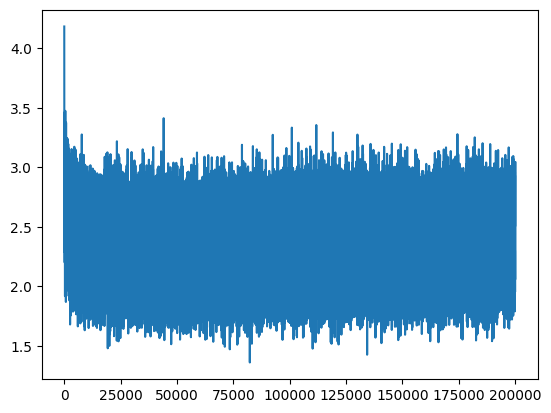

In [8]:


with torch.no_grad():
    E = C[X_val]
    E = E.view(-1, context_length * embedding_size)
    I = E @ W1 + b1
    I = (I - I_mean) / I_std
    H = torch.tanh(I)
    O = H @ W2 + b2
    loss_val = torch.nn.functional.cross_entropy(O, Y_val)
    losses_val.append(loss_val.item())
    print("validation loss: ", loss_val.item())
    if loss_val.item() < best_loss:
        best_loss = loss_val.item()

import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.show()



tanh activation problem

In [ ]:

# plt.figure(figsize=(6,6))
# plt.scatter(C[:,0].detach().numpy(), C[:,1].detach().numpy())
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], fontsize=12, ha='center', va='center', color='black')
# plt.xlabel('C[:,0]')
# plt.ylabel('C[:,1]')
# plt.title('2D Plot of C Embeddings (index as label)')
# plt.grid(True)
# plt.show()


torch.Size([205347, 3])
torch.Size([205347])
torch.Size([27, 10])
tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046])


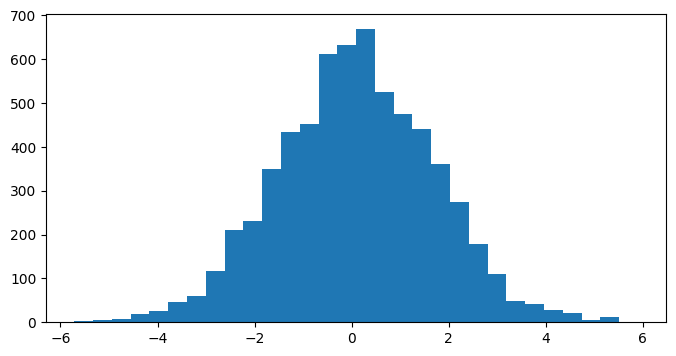

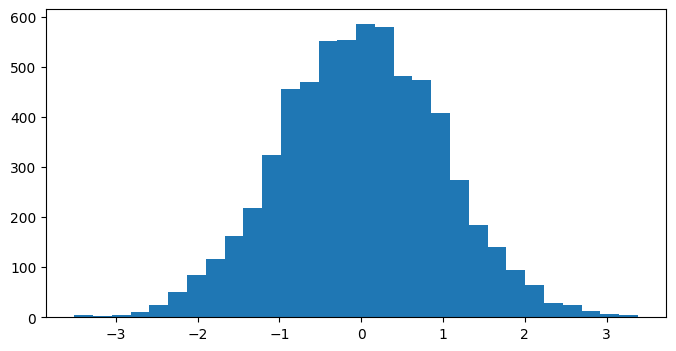

tensor([ 1.2179, -0.1882,  2.2875, -0.3985,  1.9289,  1.9489, -0.7093,  0.6244,
         1.0044,  0.2199, -0.2944, -0.0839,  0.0227, -0.4386, -0.7798, -0.6957,
        -0.6434,  1.8866,  1.1327,  0.5878,  1.0703, -0.1291, -1.7968,  0.3524,
        -1.3988, -1.1173, -1.1885,  0.4005, -0.2599, -1.3392,  0.5555, -0.1714,
        -0.0379,  0.7423, -1.1530,  0.1568, -0.5680, -0.1035,  1.0134,  0.1128,
        -1.4724,  0.8009, -0.0901, -0.3656, -0.1645,  0.9910, -1.0534,  1.0589,
         0.5598, -0.2025, -0.1351,  0.5836, -0.8951, -1.6102, -0.4911, -0.0403,
         0.6864,  0.5330,  0.7016,  0.4484,  0.6257, -1.0217, -1.3597,  1.4706,
        -0.1280,  1.2235,  0.9718,  1.0446,  0.2977,  0.2270,  0.0173,  0.2694,
         0.1250, -0.4351,  0.0716,  0.4125,  0.4945,  0.2999, -0.3341,  0.7629,
         0.9131, -0.0207,  0.6794, -1.2809, -2.0644, -0.2555,  1.1492, -1.6328,
         1.6320,  0.3997,  0.4076, -0.2142,  0.2962, -0.1437,  0.1179,  0.5443,
         0.3592, -0.9392,  0.3332, -0.96

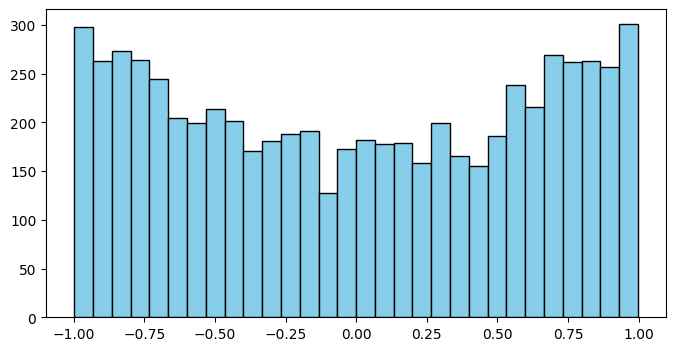

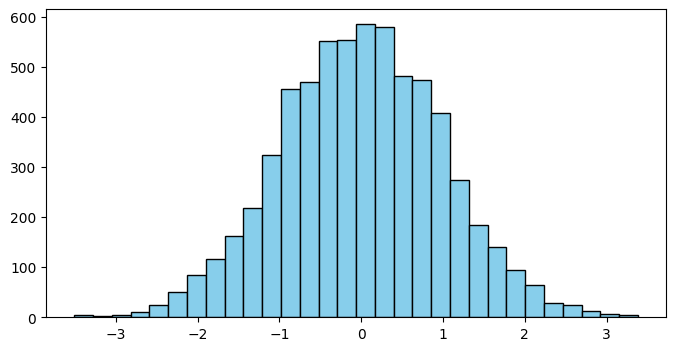

validation loss:  4.079296112060547


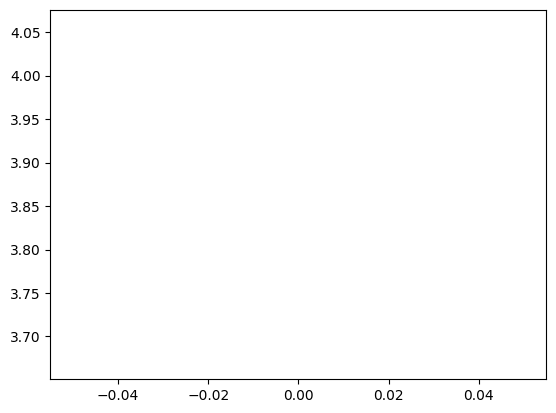

xjtjahdzj
gdszjwnses
hawgghiwgxjzpa
pcehozujpjxtzfge
ynwexjzcbw
nnrybiguhx
tfrznwelkhwzlljwnxeogeflx
ncektrzgvehjsudixhz
nunnyegkiwhvehe
tpowddjmkynnh


In [9]:
embedding_size = 10
context_length = 3
hidden_size = 200
mini_batch = 32
epochs = 200000
lr = 0.1

X_train  = []
Y_train = []
X_val = []
Y_val = []
import random
random.seed(42)
random.shuffle(names)
total_len = len(names)
train_len = int(total_len * 0.9)
val_len = total_len - train_len
train_names = names[:train_len]
val_names = names[train_len:]
for name in train_names:
    name =  name.strip()
    context = [0] * context_length
    for ch in name + '.':
        input = [itos[c] for c in context]
        
        X_train.append(context)
        Y_train.append(stoi[ch])
        context = context[1:] + [stoi[ch]]
for name in val_names:
    name =  name.strip()
    context = [0] * context_length
    for ch in name + '.':
        input = [itos[c] for c in context]
        
        X_val.append(context)
        Y_val.append(stoi[ch])
        context = context[1:] + [stoi[ch]]

import torch
g = torch.Generator().manual_seed(2147483647) # for reproducibility
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_val = torch.tensor(X_val)
Y_val = torch.tensor(Y_val)

C = torch.randn((27, embedding_size), generator=g)
print(X_train.shape)
print(Y_train.shape)
print(C.shape)
print(C[0])

#forward pass
 
W1 = torch.randn((context_length * embedding_size, hidden_size), generator=g) * (5/3) * (1/ (context_length * embedding_size)**0.5)
W2 = torch.randn((hidden_size, 27), generator=g) * (5/3) * (1/ (hidden_size)**0.5)
b1 = torch.randn((hidden_size,), generator=g) * 0.01
b2 = torch.randn((27,), generator=g) * 0.01
parameters = [W1, W2, C, b1, b2]
for p in parameters:
    p.requires_grad = True

        

losses = []
losses_val = []

best_loss = float('inf')
best_i = 0
for i in range(epochs):
    
    samples = torch.randint(0, X_train.shape[0], (mini_batch,))
    mini_batch_X = X_train[samples]
    mini_batch_Y = Y_train[samples]
    E = C[mini_batch_X]
    E = E.view(-1, context_length * embedding_size)
    I = E @ W1 + b1
    # (32 x 200) x (200)
    Iv = I.view(mini_batch * hidden_size).detach().numpy().copy()
    plt.figure(figsize=(8,4))
    plt.hist(Iv, bins=30)
    plt.show()
    I_std = I.std(dim=0, keepdim=True)  
    I_mean = I.mean(dim=0, keepdim=True)
    I = (I - I_mean) / I_std
    I = bn_scale * I + bn_shift
    Iv = I.view(mini_batch * hidden_size).detach().numpy().copy()
    plt.figure(figsize=(8,4))
    plt.hist(Iv, bins=30)
    plt.show()
    print(I[0])
    print(I.shape)
    preh = I
    H = torch.tanh(preh)
    O = H @ W2 + b2
    loss = torch.nn.functional.cross_entropy(O, mini_batch_Y) + weight_decay * (W1**2).mean() + weight_decay * (W2**2).mean() + weight_decay * (C**2).mean()
    
    loss.backward()
    losses.append(loss.item())
    print("training loss: ", loss.item())
    break
print("logits =",O[0])
H= H.view(-1).detach().numpy()
preh= preh.view(-1).detach().numpy()

plt.figure(figsize=(8,4))
plt.hist(H, bins=30, color='skyblue', edgecolor='black')
plt.show()  
plt.figure(figsize=(8,4))
plt.hist(preh, bins=30, color='skyblue', edgecolor='black')
plt.show()
with torch.no_grad():
    E = C[X_val]
    E = E.view(-1, context_length * embedding_size)
    H = torch.tanh(E @ W1 + b1)
    O = H @ W2 + b2
    loss_val = torch.nn.functional.cross_entropy(O, Y_val)
    losses_val.append(loss_val.item())
    print("validation loss: ", loss_val.item())
    if loss_val.item() < best_loss:
        best_loss = loss_val.item()

import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.show()

for i in range(10):
    test_content = ['.'] * context_length
    test_word = ''
    while True:
        input = [stoi[c] for c in test_content]
        X = C[input]
        X=X.view(-1, context_length * embedding_size)
        H = torch.tanh(X @ W1 + b1)
        O = H @ W2 + b2
        probs = torch.softmax(O, dim=-1)
        ind = torch.multinomial(probs, num_samples=1).item()
        
        test_content = test_content[1:] + [itos[ind]]
        if itos[ind] == '.':
            break
        test_word += itos[ind]
    print(test_word)




In [ ]:
logits = 1/27
print(logits)
loss = -1 * torch.log(torch.tensor(logits))
print(loss)

implication of standard deviation of a matrix multiplication operation on 2 matrix 
also explains why we do under root d in KQ in self attention 

In [ ]:
fan_in = 100
x = torch.randn((1000,100))
w = torch.randn((100,200)) / torch.sqrt(torch.tensor(fan_in))
y = x @ w
print(y.shape)
print(x.mean())
print(x.std())
print(y.mean())
print(y.std())
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(x.numpy(), bins=30 )
plt.subplot(1,2,2)
plt.hist(y.numpy(), bins=30)
plt.show()



batch normalization


In [ ]:
torch.manual_seed(42)
x = torch.randn((30,20))
w = torch.randn((20,10)) 
y = x @ w

y_std = y.std(dim=0, keepdim=True)
y_mean = y.mean(dim=0, keepdim=True)


y_0 = y[:,0].clone()

print("after batch norm")
print("y mean =", y_mean)
print(y_mean.shape)
scale = 1
shift = 0
y = (y - y_mean) / y_std
scale = torch.ones((10,)) * 2
shift = torch.zeros((10,))
y = scale * y + shift
print(y[0])
